In [3]:
# Essential tools for data handling and calculations
import pandas as pd
import numpy as np
import os

# Libraries for creating graphs and visuals
import matplotlib.pyplot as plotter
import seaborn as snchart

# Tools for splitting data and tuning model settings
from sklearn.model_selection import train_test_split, GridSearchCV

# Scaling tool to bring all numeric values to similar ranges
from sklearn.preprocessing import StandardScaler

# Machine learning algorithms used in this work
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Evaluation tools to check how well models perform
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
# Column names taken based on dataset documentation
feature_titles = [
    "col_center", "row_center", "pixel_count",
    "line_density_5", "line_density_2",
    "v_edge_avg", "v_edge_std", "h_edge_avg", "h_edge_std",
    "intensity_avg", "raw_red_avg", "raw_blue_avg", "raw_green_avg",
    "extra_red_avg", "extra_blue_avg", "extra_green_avg",
    "value_avg", "saturation_avg", "hue_avg", "label_code"
]
# File path to the dataset location
folder_path = r"C:\Users\divya\OneDrive\Documents\statlog+image+segmentation"
file_name = "segment.dat" 
dataset_location = os.path.join(folder_path, file_name)

print(f"Trying to load: {dataset_location}")
print("File exists?", os.path.isfile(dataset_location))

# Load dataset using whitespace as separator
raw_data = pd.read_csv(dataset_location, sep=r'\s+', names=feature_titles)
print("Dataset loaded successfully.")
# Mapping numeric labels to readable class names
label_names = {
    1: 'brickface', 2: 'sky', 3: 'foliage',
    4: 'cement', 5: 'window', 6: 'path', 7: 'grass'
}
raw_data['class_name'] = raw_data['label_code'].map(label_names)

# Removing a column with no useful variation
cleaned_data = raw_data.drop(columns=['pixel_count'])

Trying to load: C:\Users\divya\OneDrive\Documents\statlog+image+segmentation\segment.dat
File exists? True
Dataset loaded successfully.


In [9]:
# Separating input features and target labels
input_features = cleaned_data.drop(columns=['label_code', 'class_name'])
target_labels = cleaned_data['class_name']

# Splitting into training and testing groups
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_features, target_labels, test_size=0.2, random_state=42
)

# Scaling numerical values for distance-based models
normalizer = StandardScaler()
scaled_train_inputs = normalizer.fit_transform(train_inputs)
scaled_test_inputs = normalizer.transform(test_inputs)

print(f"Training rows: {train_inputs.shape[0]}")
print(f"Testing rows: {test_inputs.shape[0]}")

Training rows: 1848
Testing rows: 462


In [11]:
print("\n--- Running KNN Model with Grid Search ---")

# Searching best K value from 1 to 19
setting_grid = {'n_neighbors': np.arange(1, 20)}
knn_model = KNeighborsClassifier()

knn_search = GridSearchCV(knn_model, setting_grid, cv=5)
knn_search.fit(scaled_train_inputs, train_labels)

print(f"Best neighbor count: {knn_search.best_params_['n_neighbors']}")

knn_predictions = knn_search.predict(scaled_test_inputs)
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print(f"KNN Accuracy Score: {knn_accuracy:.4f}")


--- Running KNN Model with Grid Search ---
Best neighbor count: 1
KNN Accuracy Score: 0.9589


In [13]:
print("\n--- Running Linear SVM Classifier ---")

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(scaled_train_inputs, train_labels)

svm_predictions = svm_classifier.predict(scaled_test_inputs)
svm_accuracy = accuracy_score(test_labels, svm_predictions)

print(f"SVM Accuracy Score: {svm_accuracy:.4f}")


--- Running Linear SVM Classifier ---
SVM Accuracy Score: 0.9481


In [15]:
print("\n--- Running Random Forest Classifier ---")

forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
forest_classifier.fit(train_inputs, train_labels)

forest_predictions = forest_classifier.predict(test_inputs)
forest_accuracy = accuracy_score(test_labels, forest_predictions)

print(f"Random Forest Accuracy Score: {forest_accuracy:.4f}")


--- Running Random Forest Classifier ---
Random Forest Accuracy Score: 0.9719


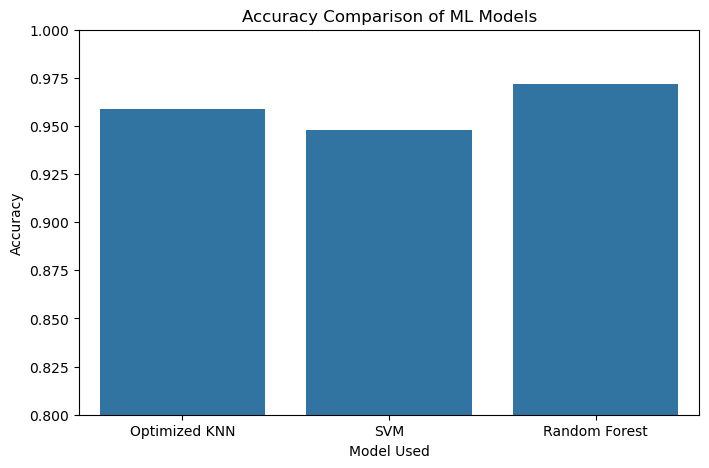

In [17]:
# Comparing all three models
results_sheet = pd.DataFrame({
    'Model Used': ['Optimized KNN', 'SVM', 'Random Forest'],
    'Accuracy Score': [knn_accuracy, svm_accuracy, forest_accuracy]
})

plotter.figure(figsize=(8, 5))
snchart.barplot(x='Model Used', y='Accuracy Score', data=results_sheet)
plotter.ylim(0.8, 1.0)
plotter.title('Accuracy Comparison of ML Models')
plotter.ylabel('Accuracy')
plotter.savefig('model_comparison_graph.png')
plotter.show()

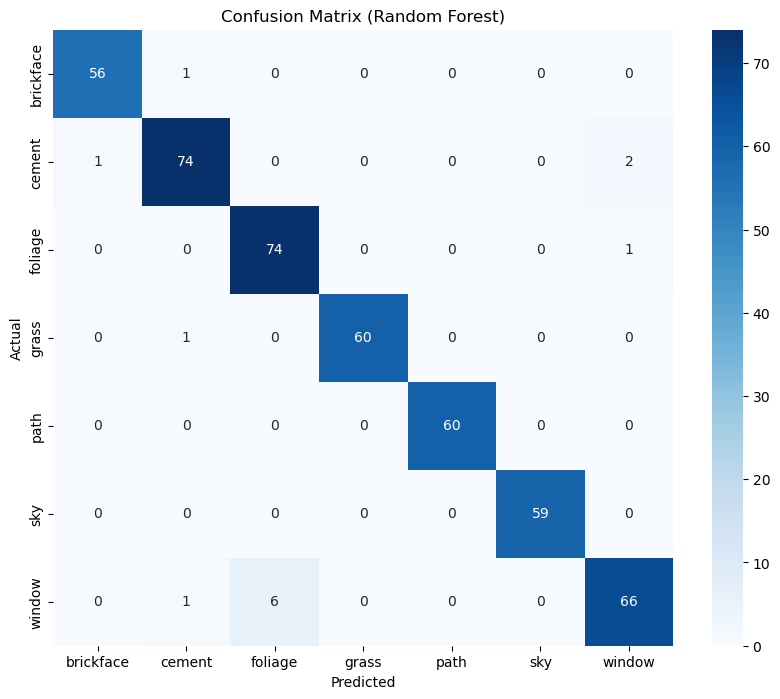

In [19]:
# Confusion matrix for Random Forest
plotter.figure(figsize=(10, 8))
cmatrix = confusion_matrix(test_labels, forest_predictions, labels=forest_classifier.classes_)
snchart.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=forest_classifier.classes_,
                yticklabels=forest_classifier.classes_)

plotter.title('Confusion Matrix (Random Forest)')
plotter.xlabel('Predicted')
plotter.ylabel('Actual')
plotter.savefig('confusion_matrix_graph.png')
plotter.show()

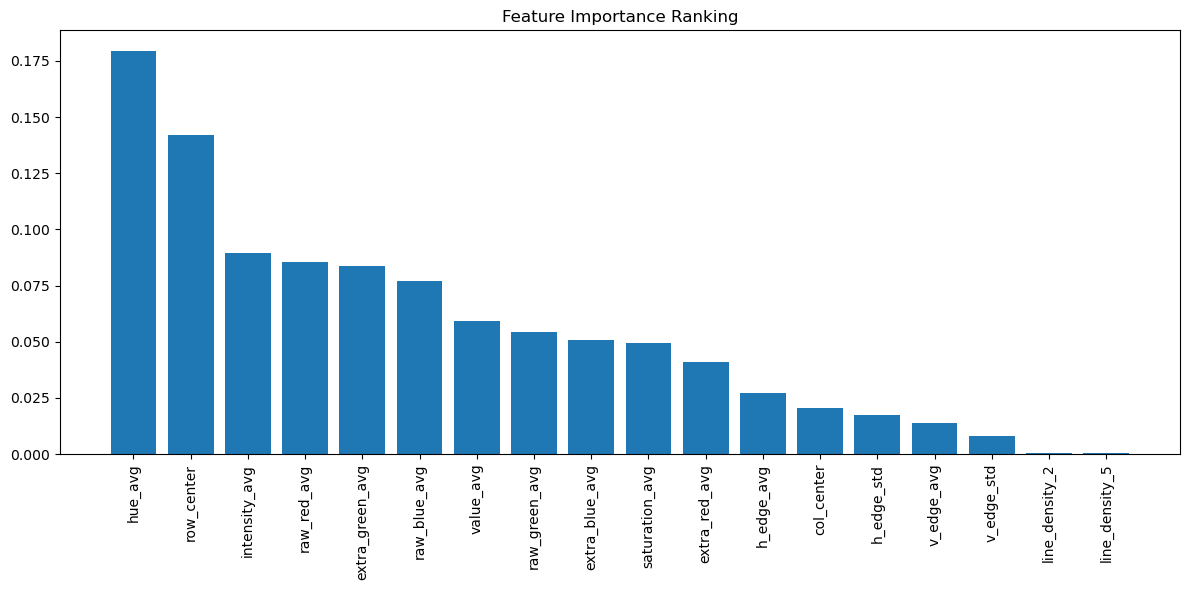


Analysis completed. All graphs saved.


In [21]:
# Feature importance chart
importance_values = forest_classifier.feature_importances_
order_indices = np.argsort(importance_values)[::-1]

plotter.figure(figsize=(12, 6))
plotter.title("Feature Importance Ranking")
plotter.bar(range(input_features.shape[1]), importance_values[order_indices])
plotter.xticks(range(input_features.shape[1]),
               input_features.columns[order_indices],
               rotation=90)

plotter.tight_layout()
plotter.savefig('feature_importance_graph.png')
plotter.show()

print("\nAnalysis completed. All graphs saved.")